# Drugs Classifier using Decision Tree

Here [Drug Classification](https://www.kaggle.com/prathamtripathi/drug-classification) dataset by [Pratham Tripathi](https://www.kaggle.com/prathamtripathi) is used to create a classifier that classifies `drugs` on the basis of it `properites` using `Decision Tree`.

![](https://media.giphy.com/media/xT8qB2zDVGj7ly4moU/giphy.gif)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

# Models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from joblib import dump

In [2]:
df = pd.read_csv('/kaggle/input/drug-classification/drug200.csv')
df.sample(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
8,60,M,NORMAL,HIGH,15.171,DrugY
78,19,F,HIGH,HIGH,13.313,drugA
30,18,F,NORMAL,NORMAL,8.750,drugX
80,60,M,HIGH,HIGH,13.934,drugB
95,36,M,LOW,NORMAL,11.424,drugX


## 🏋️‍♀️ Data preparation

Looing if the dataset is `balanced` or not.

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64


<AxesSubplot:xlabel='Drug', ylabel='count'>

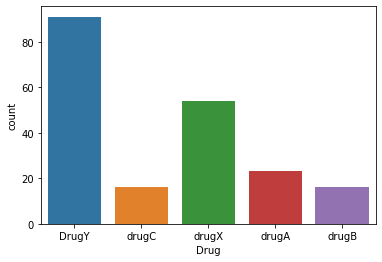

In [3]:
print(df.Drug.value_counts())
sns.countplot(x='Drug', data=df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


`Label encoding vs OneHot encoding` 👉 [Source_1](https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b) and [Source_2](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor)

In [5]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [6]:
def data_encoding(df):
    df.Sex = LabelEncoder().fit_transform(df.Sex)
    df.BP = LabelEncoder().fit_transform(df.BP)
    df.Cholesterol = LabelEncoder().fit_transform(df.Cholesterol)


# data_encoding(df)
# df.head()

This will be done after `EDA` so that we can get insight into data & don't need to worry about mapping fig plot's x & y labels to original values

- Sex
    - Female - 0
    - Male - 1
- BP
    - HIGH - 0
    - LOW - 1
    - Normal - 2
- Cholesterol
    - HIGH - 0
    - LOW - 1
    
Since we are using `DecisionTreeClassifier` algorithm for classification, `LabelEncoding` is ok, otherwise if we are using something else where numbers matter, there we should use `OneHotEncoding`.

## 🍩 Exploratory Data Analysis

In [7]:
''' Helper functions for plotting '''


def plot_histplot(column, ax=None):
    sns.histplot(x=column, color='#65b87b', alpha=.7, ax=ax)
    
    
def plot_countplot(column, ax=None):
    with sns.axes_style('ticks'):
        sns.countplot(x=column, palette=sns.color_palette('rocket'), ax=ax)
        sns.despine(offset=6)
        
        
def plot_barplot(x, y, ax=None):
    sns.barplot(x=x, y=y, palette=sns.color_palette('rocket'))
    
    
def plot_boxplot(x, y, ax=None):
    sns.boxplot(x=x, y=y)

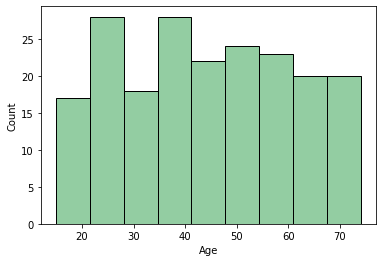

In [8]:
plot_histplot(df.Age)

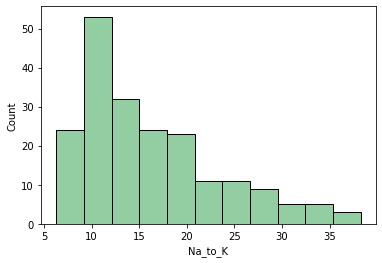

In [9]:
plot_histplot(df.Na_to_K)

Text(0.5, 1.0, 'Female - BP')

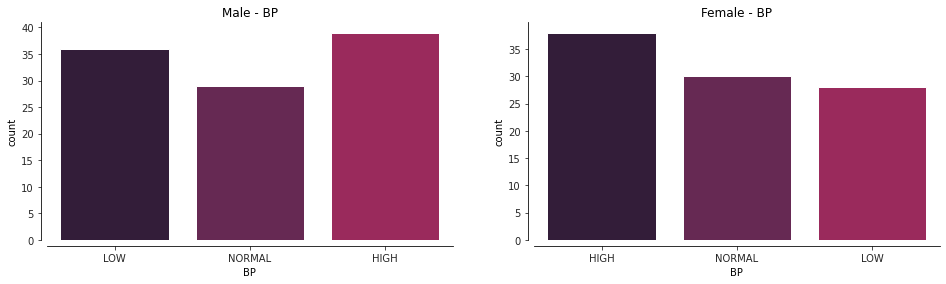

In [10]:
f, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_countplot(df[df.Sex == 'M'].BP, ax=ax[0])
plot_countplot(df[df.Sex == 'F'].BP, ax=ax[1])

ax[0].set_title('Male - BP')
ax[1].set_title('Female - BP')

Less number of `males` have `normal BP` compared to `females`. Large proportion of both the genders have a `high BP`

Text(0.5, 1.0, 'Female - Cholesterol')

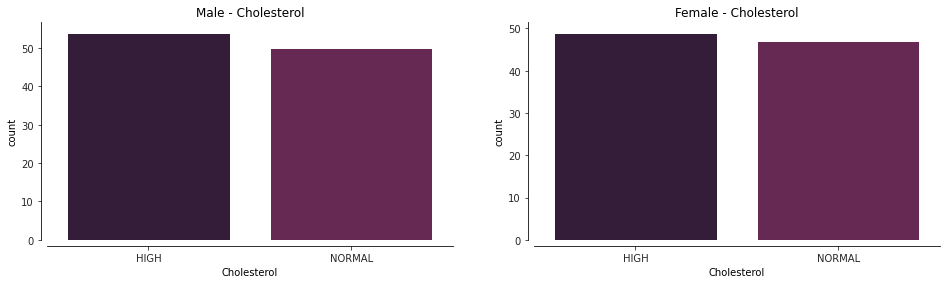

In [11]:
f, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_countplot(df[df.Sex == 'M'].Cholesterol, ax=ax[0])
plot_countplot(df[df.Sex == 'F'].Cholesterol, ax=ax[1])

ax[0].set_title('Male - Cholesterol')
ax[1].set_title('Female - Cholesterol')

Both `male` & `female` have `high cholesterol`

<AxesSubplot:xlabel='Age', ylabel='Na_to_K'>

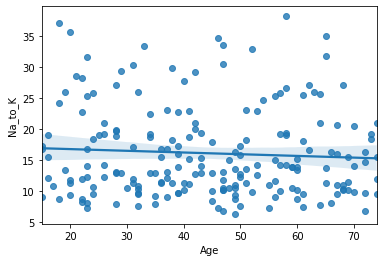

In [12]:
sns.regplot(x=df.Age, y=df.Na_to_K)

`Age` is not correlated to `Na_to_K`

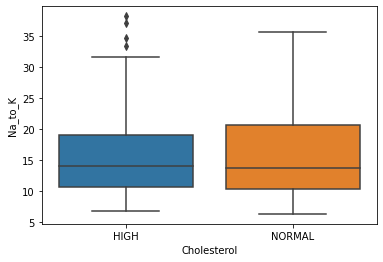

In [13]:
plot_boxplot(df.Cholesterol, df.Na_to_K)

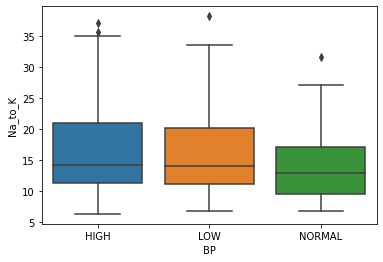

In [14]:
plot_boxplot(df.BP, y=df.Na_to_K)

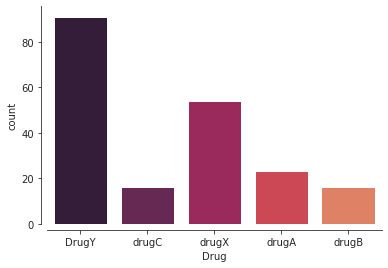

In [15]:
plot_countplot(df.Drug)

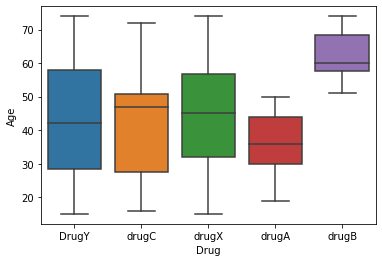

In [16]:
plot_boxplot(df.Drug, df.Age)

> `drugB` is majorly consumed by people whose age is greater than 60 while other durgs are majorly consumed by people whose age is lesser than 60.
>
> `DrugY` is consumed more than other drugs while `drugB` and `drugA` are consumed by less number of people

### Data preparation: Encoding

In [17]:
data_encoding(df)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,DrugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,DrugY


- Sex
    - Female - 0
    - Male - 1
- BP
    - HIGH - 0
    - LOW - 1
    - NORMAL - 2
- Cholesterol
    - HIGH - 0
    - NORMAL - 1
    
Since we are using `DecisionTreeClassifier` algorithm for classification, `LabelEncoding` is ok, otherwise if we are using something else where numbers matter, there we should use `OneHotEncoding`.

## 🍀 Modelling

Let's create our `AI`.

![](https://media.giphy.com/media/xT0xepagSrUXfM1eNi/giphy.gif)

In [18]:
x = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
y = df.Drug.values

# Scaling x
x = StandardScaler().fit_transform(x)

print(f'Dataset size: {len(x)}')

Dataset size: 200


In [19]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=3
)

print(f'Training set size: {len(x_train)}')
print(f'Test set size: {len(x_test)}')

Training set size: 140
Test set size: 60


In [20]:
# For cross validation
skf = StratifiedKFold(n_splits=10)

In [21]:
models = [
    LogisticRegression(), 
    SGDClassifier(), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
]

In [22]:
for model in models:
    scores = cross_val_score(model, x_train, y_train, cv=skf)
    print(f'== {model} ==')
    print(f'Cross-Validation mean-score: {scores.mean()}')
    
    print()

== LogisticRegression() ==
Cross-Validation mean-score: 0.9571428571428571

== SGDClassifier() ==
Cross-Validation mean-score: 0.8857142857142858

== KNeighborsClassifier() ==
Cross-Validation mean-score: 0.8142857142857143

== GaussianNB() ==
Cross-Validation mean-score: 0.8357142857142857

== DecisionTreeClassifier() ==
Cross-Validation mean-score: 0.9928571428571429

== RandomForestClassifier() ==
Cross-Validation mean-score: 0.9928571428571429

== SVC() ==
Cross-Validation mean-score: 0.95



In [23]:
# Parameter tuning

def dt_param_selection(x, y, nfolds):
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_depth = [1, 2, 3, 4, 5]

    param_grid = {
        'criterion': criterion, 
        'splitter': splitter, 
        'max_depth': max_depth
    }

    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=nfolds)
    grid_search.fit(x, y)
    return grid_search.best_params_


best_params_ = dt_param_selection(x_train, y_train, skf)
best_params_

{'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}

In [24]:
# Cross Validation

model = DecisionTreeClassifier(criterion='gini', max_depth=4, splitter='best')
scores = cross_val_score(model, x_train, y_train, cv=skf)
print(scores.mean())

0.9928571428571429


In [25]:
model = DecisionTreeClassifier(criterion='gini', max_depth=4, splitter='best')
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

## 🦋 Evaluation

In [26]:
y_test_pred = model.predict(x_test)

print(f"Prediction: \n{pd.DataFrame(y_test_pred)[0].value_counts()}")

Prediction: 
DrugY    23
drugX    20
drugA     7
drugC     5
drugB     5
Name: 0, dtype: int64


In [27]:
print(f"Actual: \n{pd.DataFrame(y_test).value_counts()}")

Actual: 
DrugY    22
drugX    21
drugA     7
drugB     5
drugC     5
dtype: int64


In [28]:
print(f'Model Score: {model.score(x_test, y_test)}')
print(f'f1-score: {f1_score(y_test, y_test_pred, average="weighted")}')
print(f'precision score: {precision_score(y_test, y_test_pred, average="weighted")}')
print(f'recall score: {recall_score(y_test, y_test_pred, average="weighted")}')

Model Score: 0.9833333333333333
f1-score: 0.9833152664859981
precision score: 0.9840579710144927
recall score: 0.9833333333333333


In [29]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        22
       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         5
       drugC       1.00      1.00      1.00         5
       drugX       1.00      0.95      0.98        21

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60



In [30]:
# Saving the model
dump(model, 'model.joblib')

['model.joblib']

### 🐚 Visualization

In [31]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 897 kB/s 
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=ca4a2e58285b6255510b8beca748fe6a4eda3df8d805376855de1e66bda209a0
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [32]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

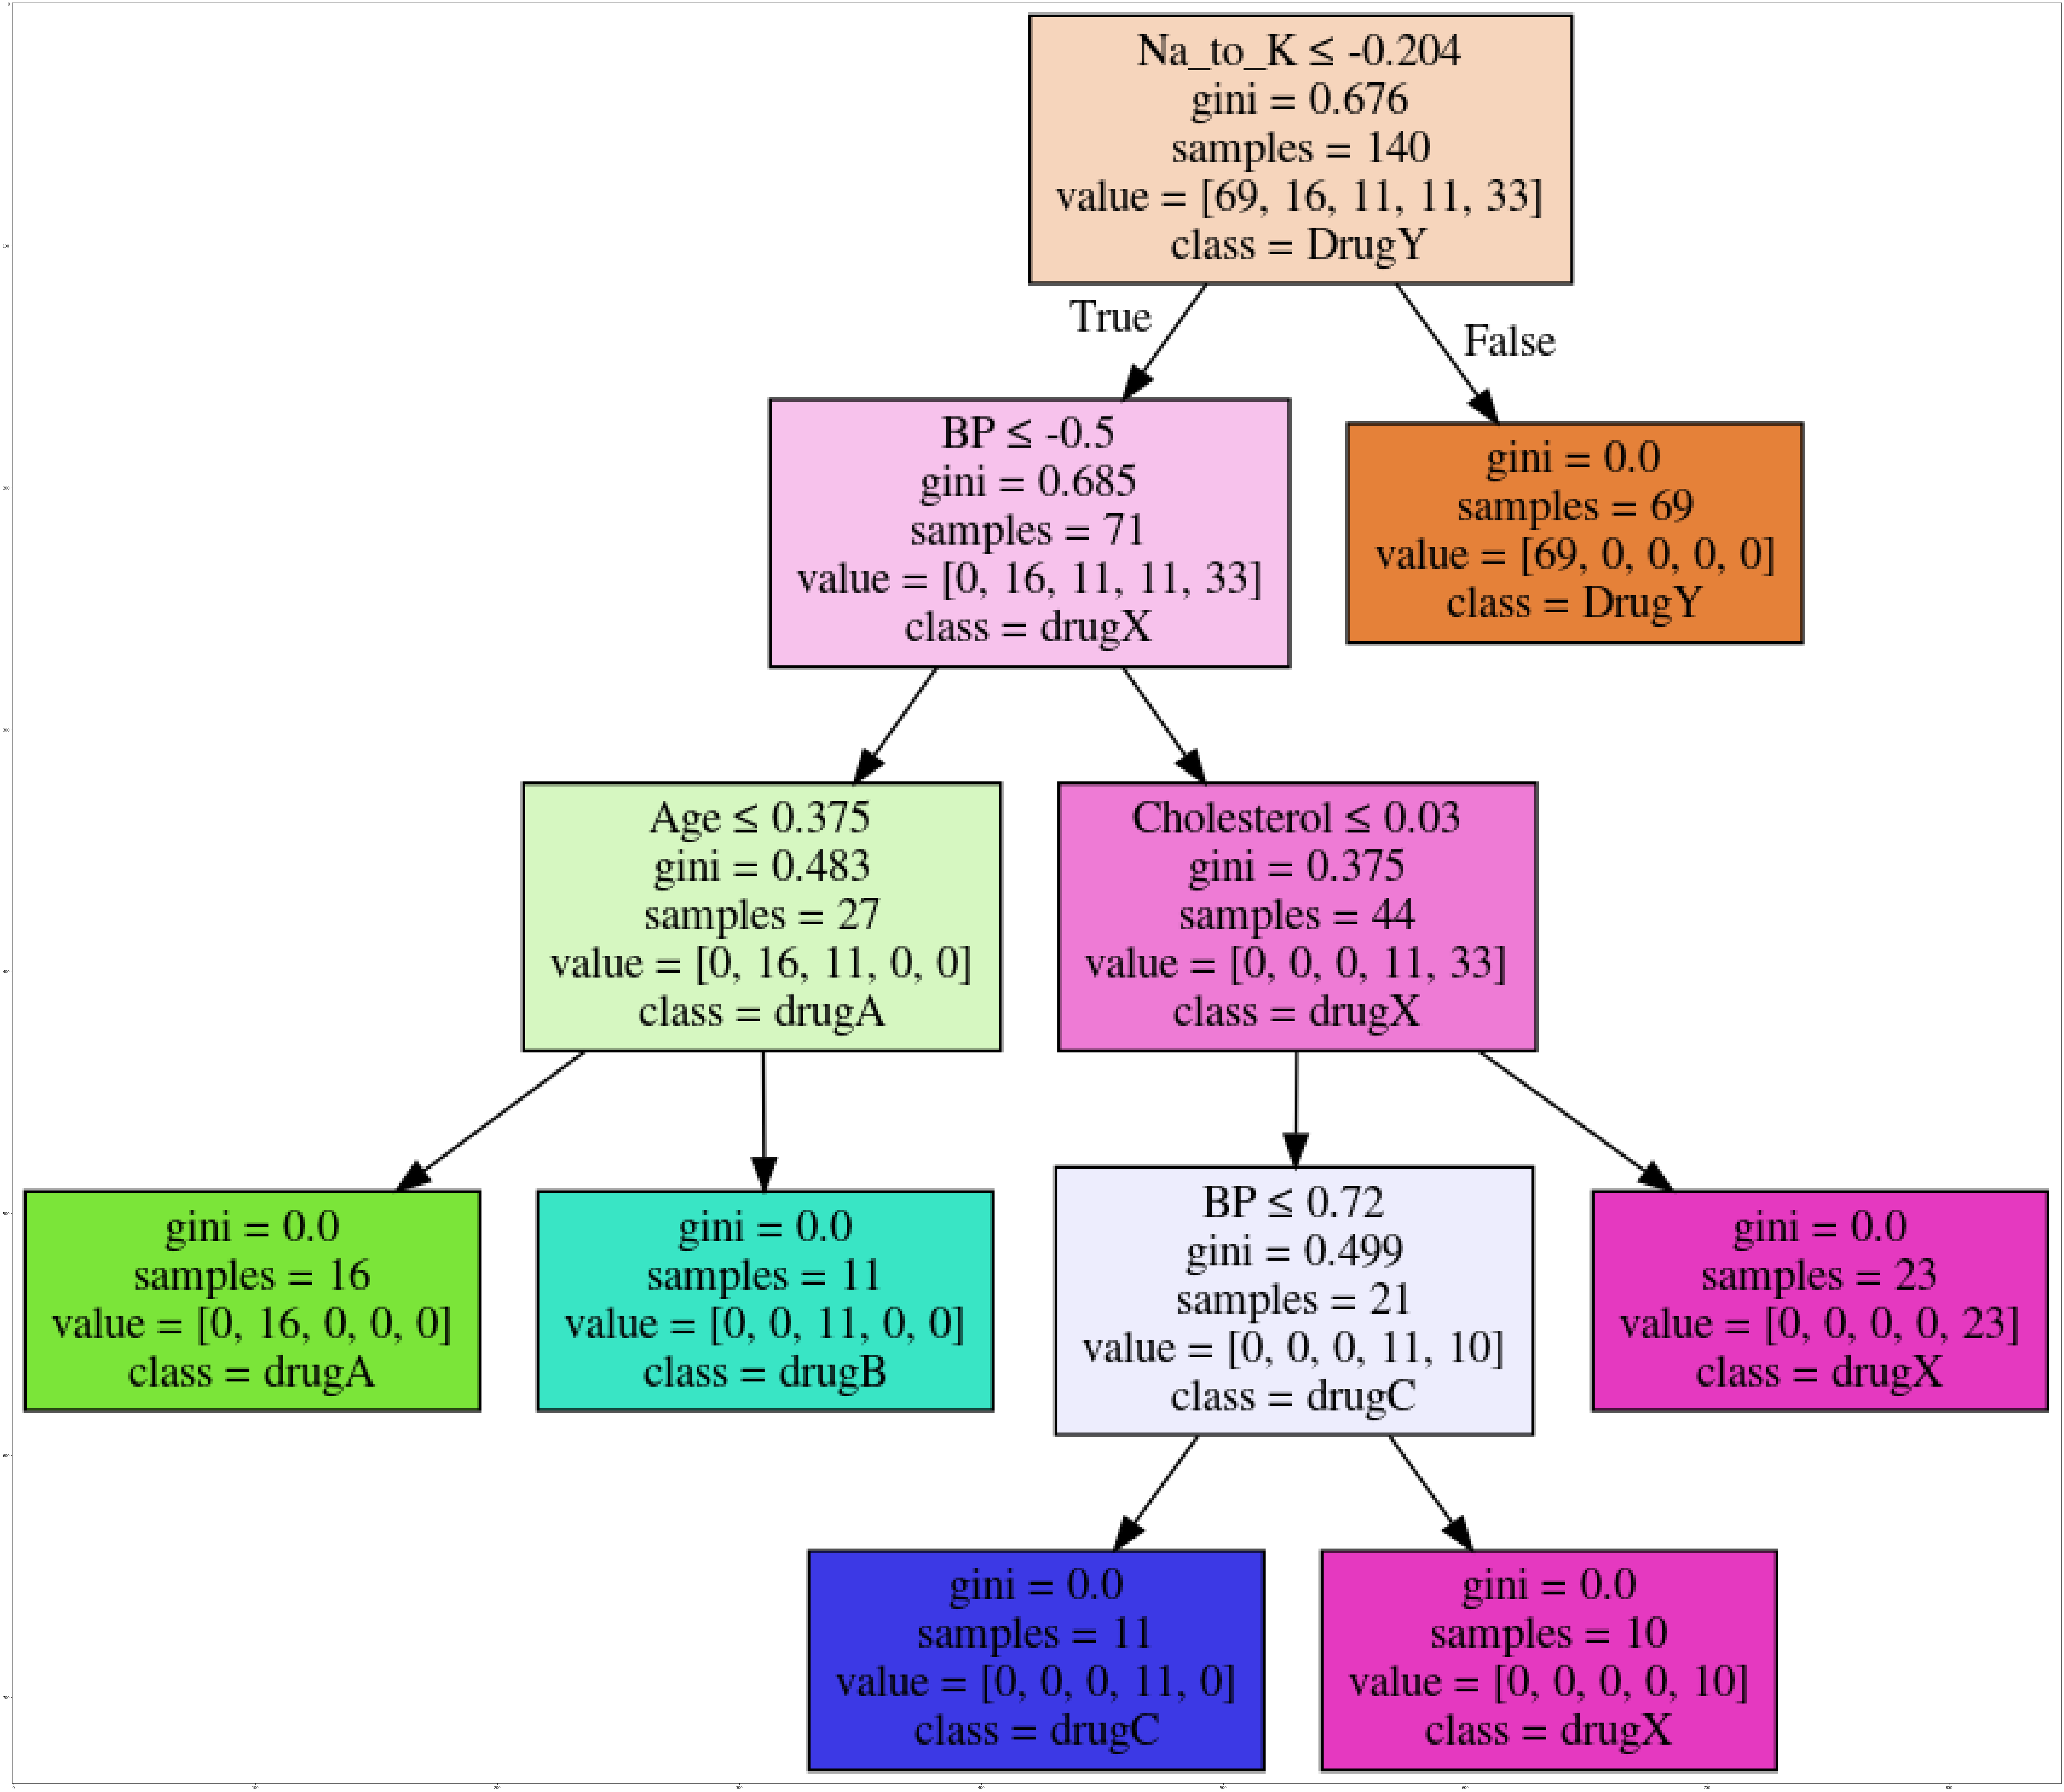

In [33]:
dot_data = StringIO()

filename = "drugtree.png"
featureNames = df.columns[0:5]
targetNames = df["Drug"].unique().tolist()

out=tree.export_graphviz(model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/Md9UQRsv94yCAjeA1w/giphy.gif)

---